In [138]:
from typing import Any

import os
from os.path import join
import shutil
import random

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from settings import *
from validation_model import ValidationModel

In [139]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [140]:
random.seed(42)

all_faces = os.listdir(FACE_DIR)
all_faces = [f'{FACE_DIR}/{face}' for face in all_faces]

random.shuffle(all_faces)

## Manual labeling

In [132]:
def plot_images(image_names):
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax_row in enumerate(ax):
        for j, ax in enumerate(ax_row):
            index = i * 10 + j
            if index < len(image_names):
                img_name = image_names[index]
                img = mpimg.imread(img_name)
                ax.imshow(img)
                title = f'{index+1}  {img_name.split("/")[-1].split(".")[0]}'
                ax.set_title(title, fontsize=8)
                ax.set_xlabel(str(index), fontsize=8, color='blue')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

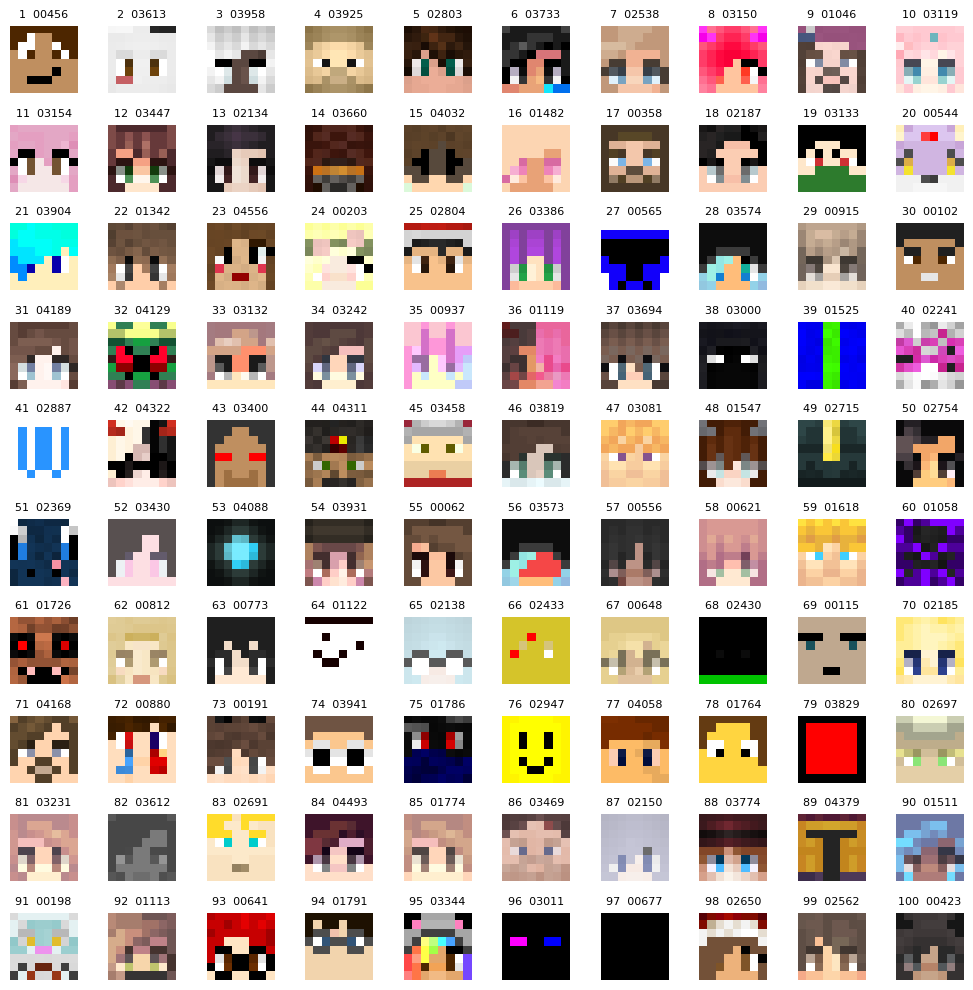

In [141]:
plot_images(all_faces[:100])

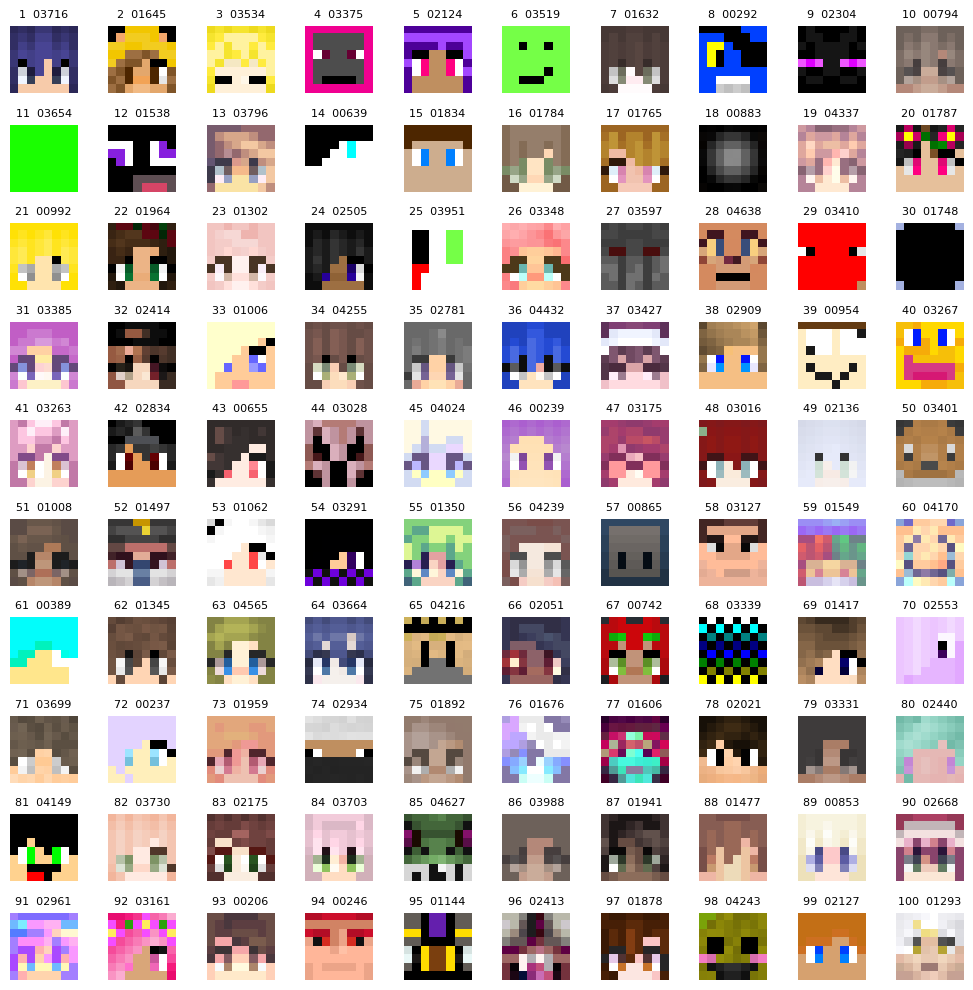

In [143]:
plot_images(all_faces[100:200])

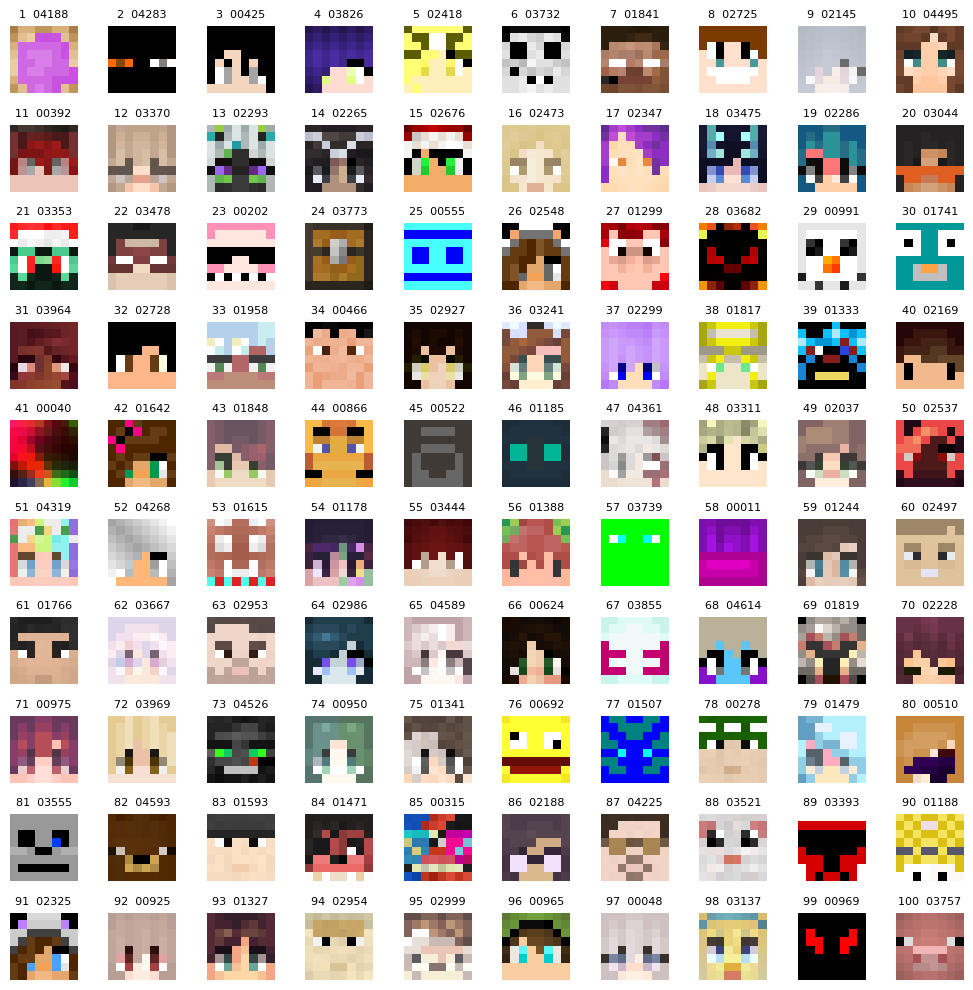

In [145]:
plot_images(all_faces[200:300])

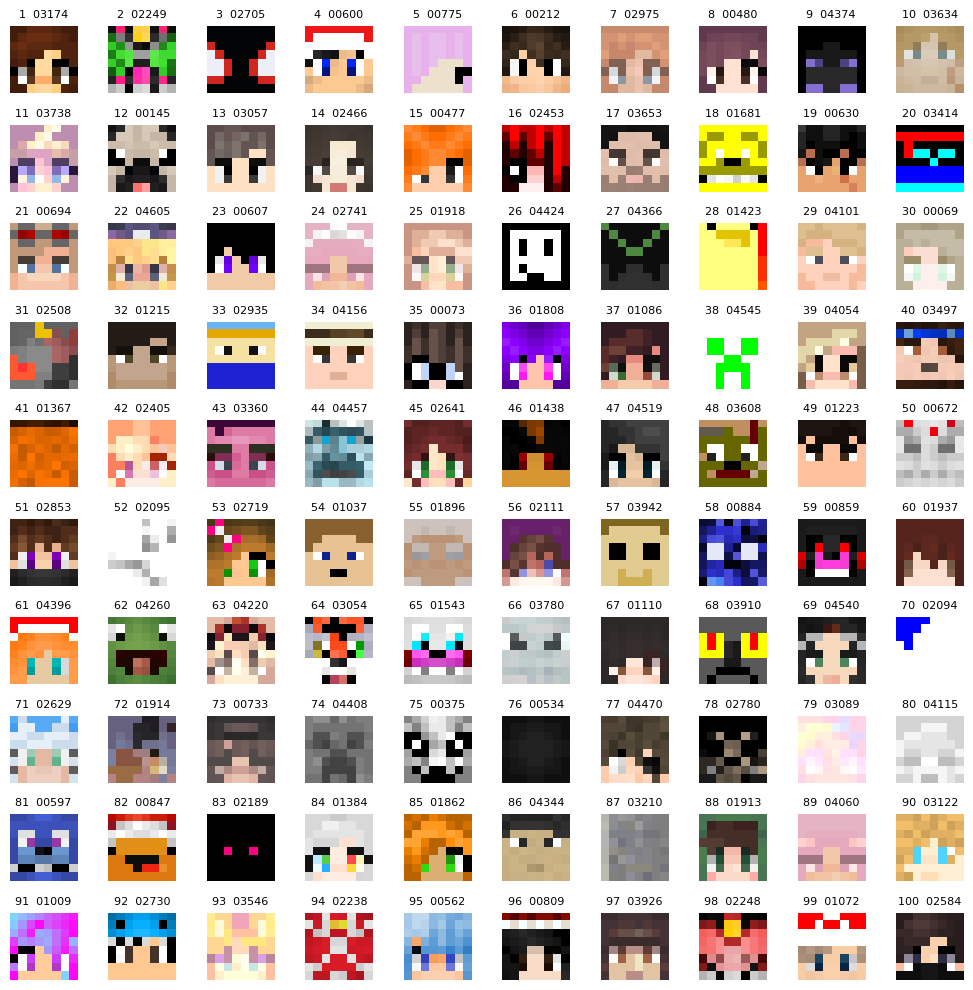

In [147]:
plot_images(all_faces[300:400])

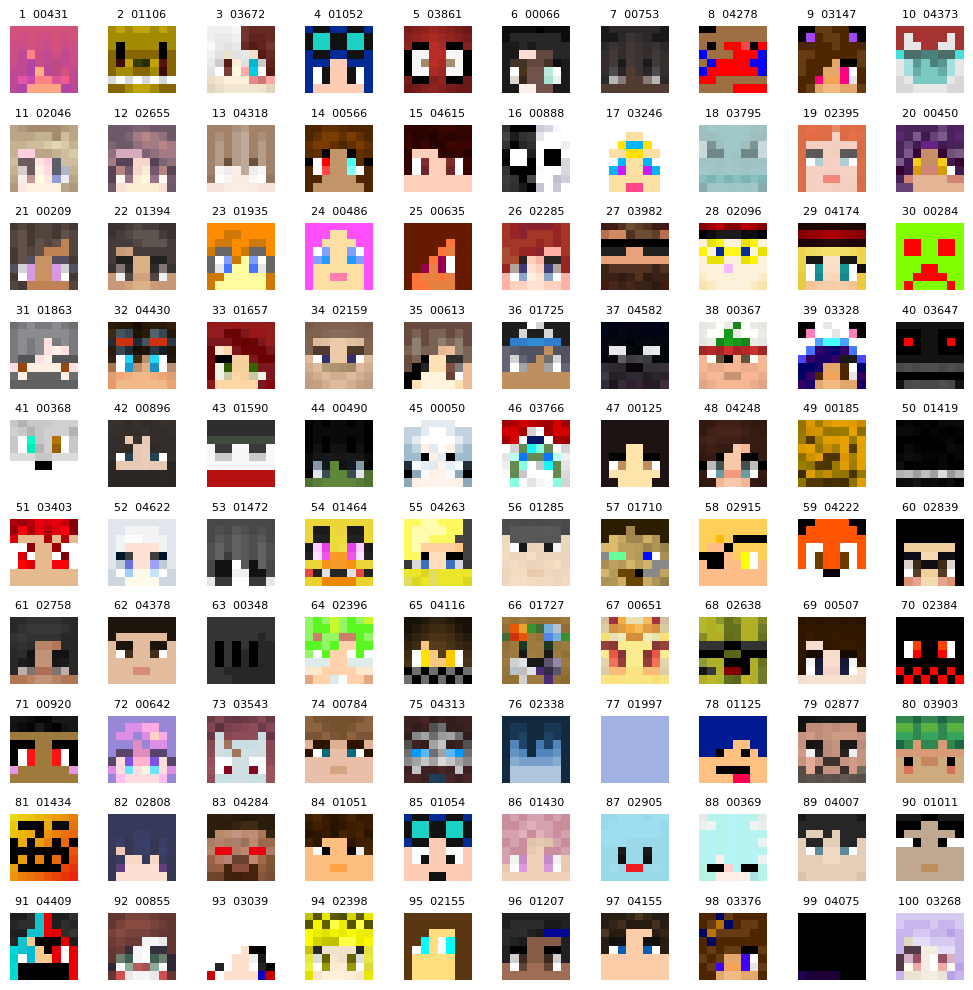

In [149]:
plot_images(all_faces[400:500])

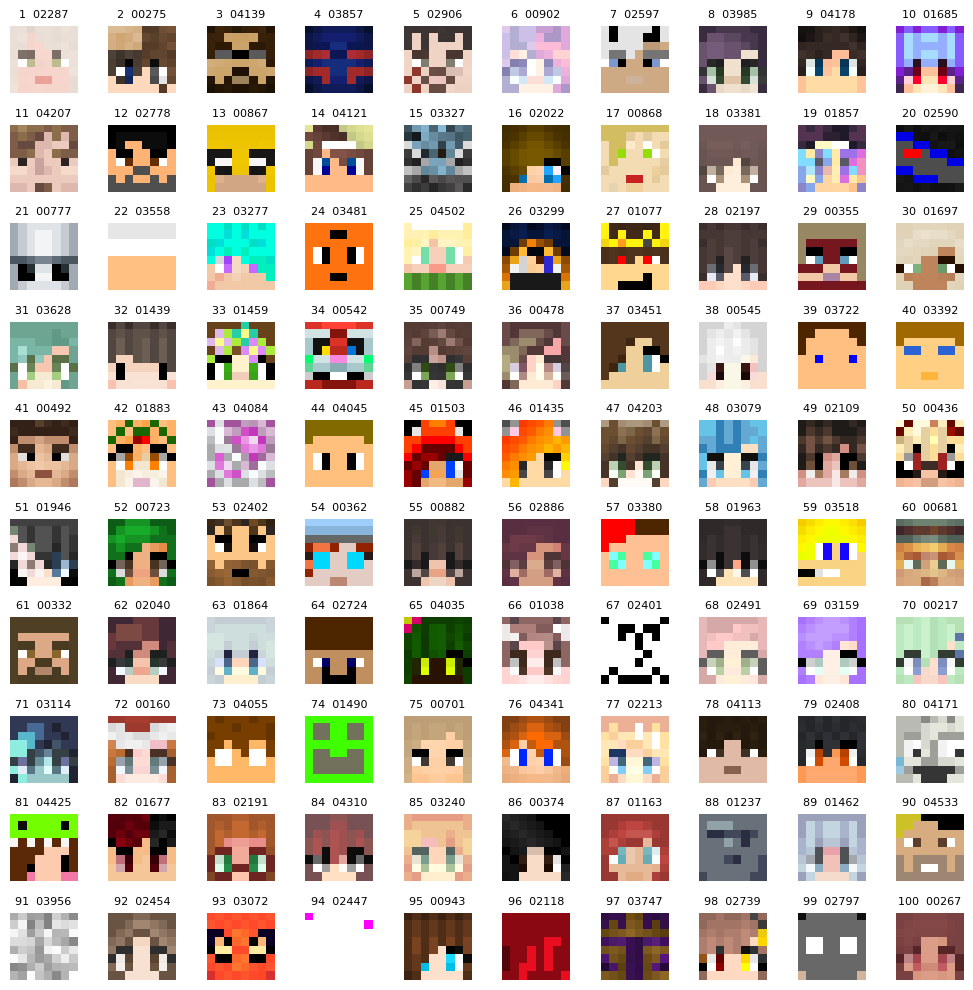

In [133]:
plot_images(all_faces[500:600])

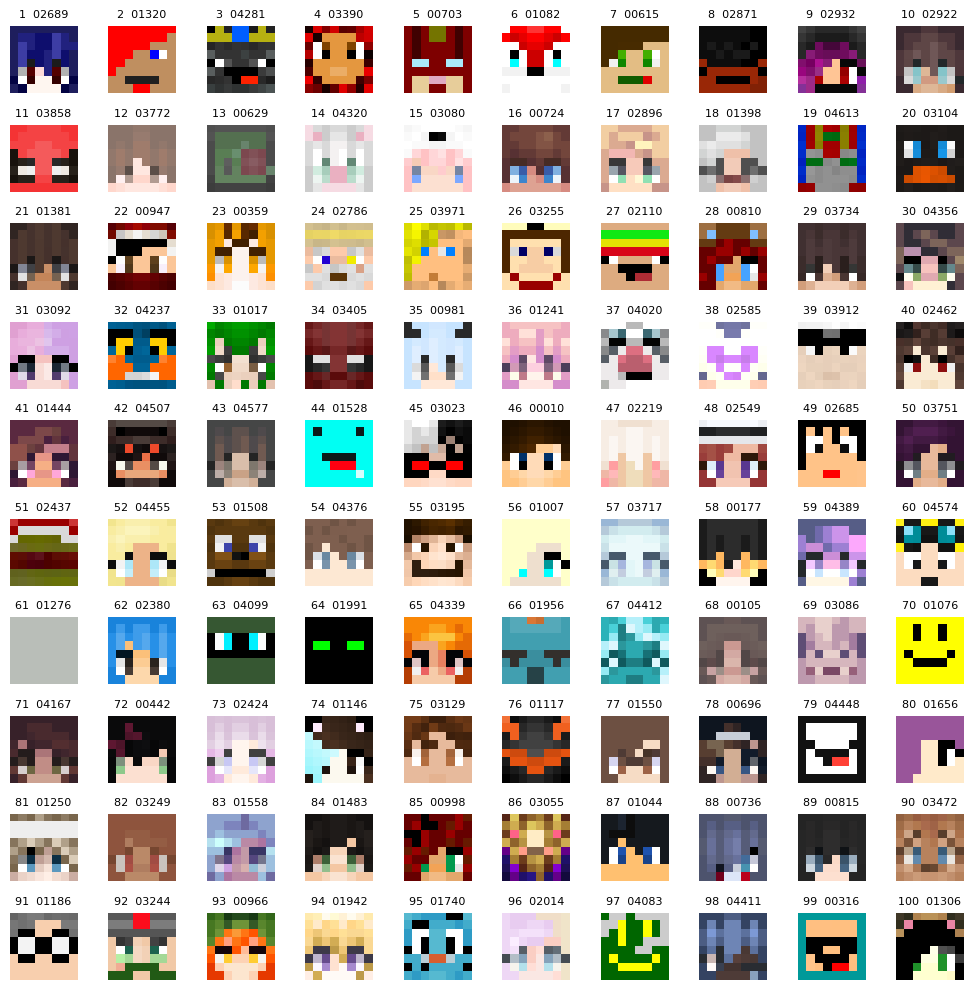

In [134]:
plot_images(all_faces[600:700])

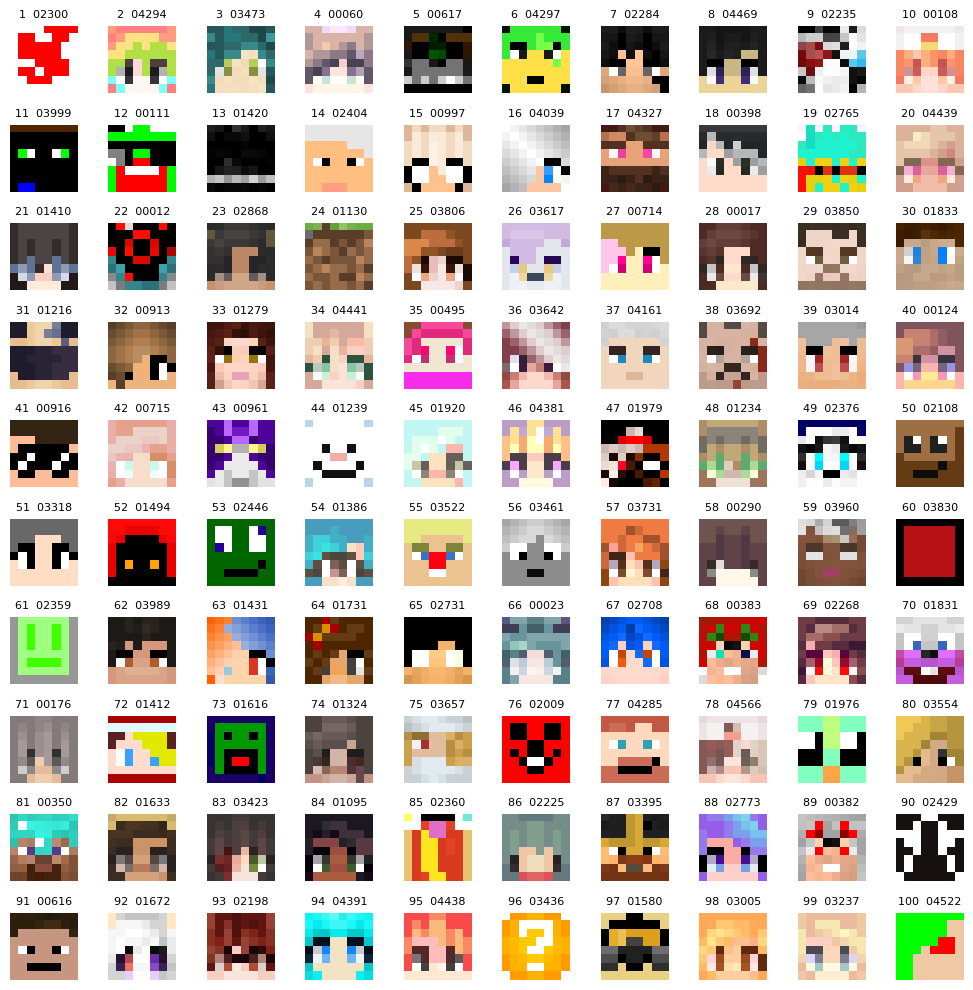

In [135]:
plot_images(all_faces[700:800])

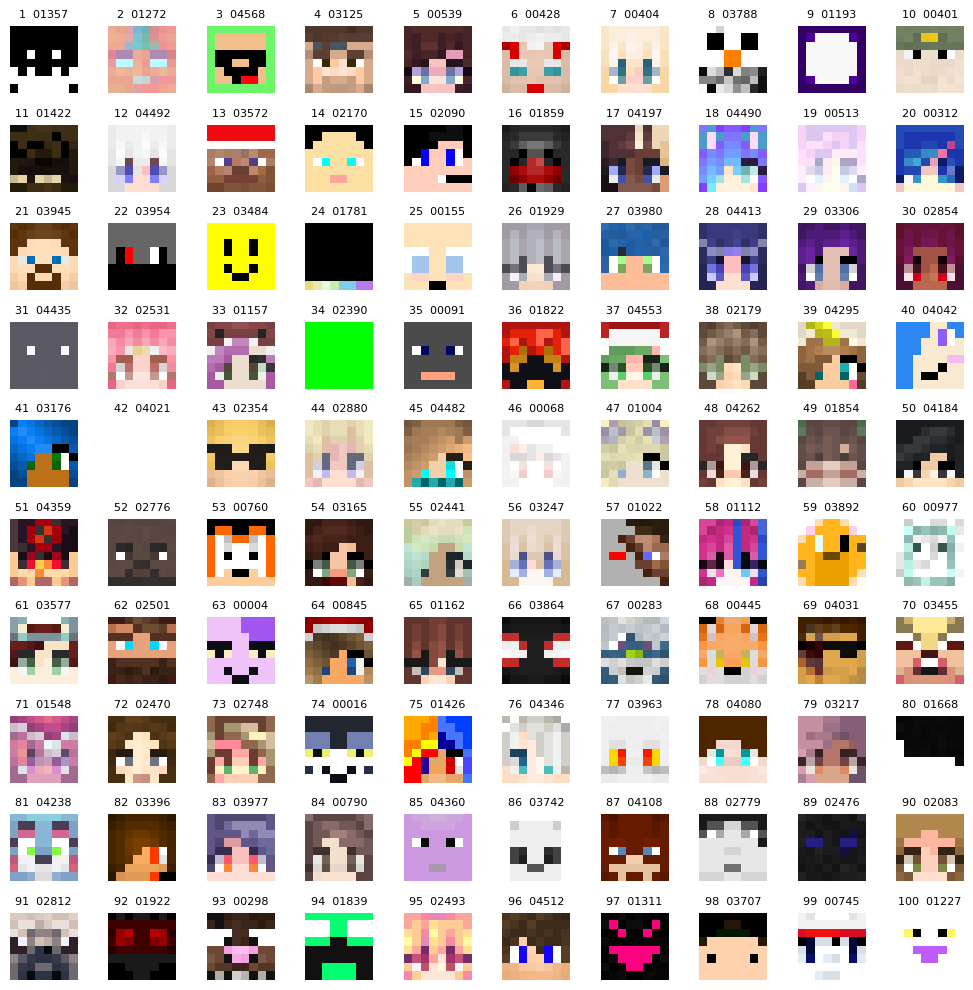

In [136]:
plot_images(all_faces[800:900])

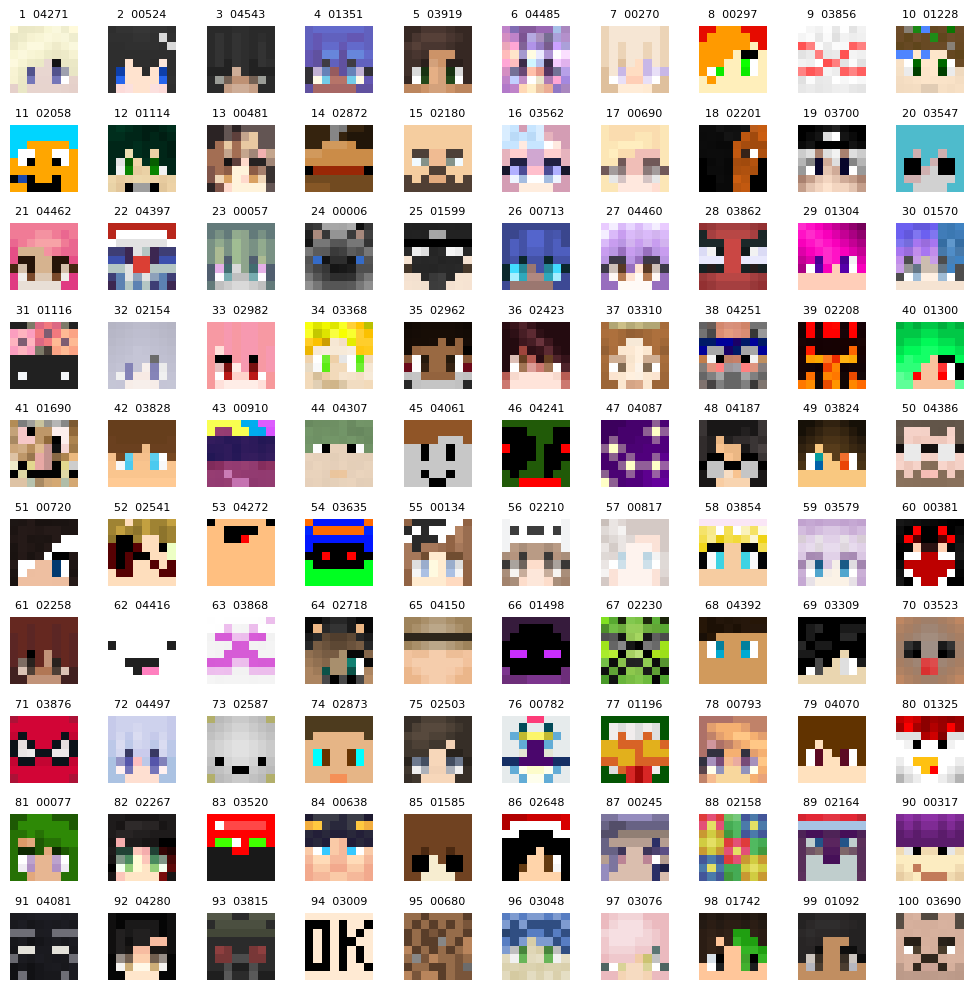

In [137]:
plot_images(all_faces[900:1000])

In [209]:
labels_str = ''
labels_str += '1001111111111000110011101101111001101000001111110101011011100110001001101100110111111111010000100111'
labels_str += '1100101001001001101111110100001111111100111011110010101101000111011010111010011011110110001110001001'
labels_str += '0011101111100111111000000100001111111001011000011011011000111011110000100110001000100000001110011000'
labels_str += '1001011101101110101011111000100101011011011010101010110100001010001010101000000001011101111110111011'
labels_str += '0001001010111110101111111100101111110110010000110001001100001100000010110100011100111100111101111101'
labels_str += '1110111111110101111000101111101100011100110011111001111101111110110111010011111001111110110100100101'
labels_str += '1000001011010001110011100011111000110011111001011101011100110100100000101110110011111010110110010001'
labels_str += '0111001101000011110110101011110111011111010011001000001110100111111110110100010111010011101001100110'
labels_str += '0101100001011110111010000111110110001110101110110101011101001101100010011011011001110000010000110000'
labels_str += '1011111101111011101010100110110111011001010100011100001111101001000100010110011011010110000100010011'

## Data augmentation

In [210]:
labeled_faces = all_faces[:1000]
label_list = [int(char) for char in labels_str]

Copy the labeled faces into `SAMPLE_FACE_DIR` path

In [211]:
if not os.path.isdir(SAMPLE_FACE_DIR):
    os.mkdir(SAMPLE_FACE_DIR)

for i, labeled_face_path in enumerate(labeled_faces):
    name = labeled_face_path.split('/')[-1]
    new_path = join(SAMPLE_FACE_DIR, name)
    
    shutil.copy(labeled_face_path, new_path)
    
    labeled_faces[i] = new_path

del i, labeled_face_path

Save flipped version of valid faces if they're less than 90% symmetric

In [212]:
flipped_faces = []
flipped_labels = []

for i, label in enumerate(label_list):
    if not label:
        continue

    curr_face_img = np.array(Image.open(labeled_faces[i]))
    flipped = np.flip(curr_face_img, axis=1)

    sym_rate = (curr_face_img == flipped).all(axis=2).sum() / 64

    if sym_rate < 0.9:
        # new name
        name = labeled_faces[i]
        name = name.split('/')[-1]
        name = name.split('.')[0]
        new_name = join(SAMPLE_FACE_DIR, name + '_flipped.png')

        # save
        Image.fromarray(flipped).save(new_name)

        # append to arrays
        flipped_faces.append(new_name)
        flipped_labels.append(1)

labeled_faces.extend(flipped_faces)
label_list.extend(flipped_labels)

print(f'flipped {len(flipped_labels)} faces')

del i, label, flipped_faces, flipped_labels, curr_face_img, flipped, sym_rate, name, new_name

flipped 481 faces


Generate random images and label as 0

In [213]:
num_arrays = 300

for _ in range(num_arrays):
    random_array = np.random.randint(0, 256, size=(8, 8, 3), dtype=np.uint8)
    name = join(SAMPLE_FACE_DIR, f'random_{_}.png')

    # save
    Image.fromarray(random_array).save(name)
    
    # append to arrays
    labeled_faces.append(name)
    label_list.append(0)

print(f'generated {num_arrays} random images')

del _, num_arrays, random_array, name

generated 300 random images


Convert to gray scale with the same label

In [199]:
total = 400
gray_faces = []
gray_face_labels = []

for i, labeled_face_path in enumerate(labeled_faces):
    if total == 0:
        break

    name = labeled_face_path.split('/')[-1]
    name = name.split('.')[0]
    name = join(SAMPLE_FACE_DIR, name + '_gray.png')

    img = Image.open(labeled_face_path).convert('L')
    img = np.array(img)[..., np.newaxis]
    img = np.tile(img, (1, 1, 3))
    Image.fromarray(img).save(name)

    gray_faces.append(name)
    gray_face_labels.append(label_list[i])

    total -= 1

labeled_faces.extend(gray_faces)
label_list.extend(gray_face_labels)

print(f'gray-scaled {len(gray_face_labels)} images')

del total, gray_faces, gray_face_labels, labeled_face_path, i, name

gray-scaled 400 images


## Train model

In [158]:
import joblib
label_list, labeled_faces = joblib.load('./samples-2.joblib')

2281

In [214]:
import importlib
import validation_model
importlib.reload(validation_model)
from validation_model import ValidationModel

In [215]:
class FaceDataset(Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.transform = transforms.ToTensor()

        self.images = images.copy()
        self.labels = labels.copy()
        self.labels = torch.tensor(self.labels,
                                   dtype=torch.float,
                                   device=DEVICE).unsqueeze(1)

    def __getitem__(self, index) -> Any:
        img = Image.open(self.images[index])
        img = self.transform(img).to(device=DEVICE)
        
        return img, self.labels[index]

    def __len__(self):
        return len(self.labels)


In [216]:
# constants
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

dataset = FaceDataset(labeled_faces, label_list)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# model instance
model = ValidationModel()

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Train the model

In [217]:
losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    for batch_imgs, batch_labels in dataloader:
        
        optimizer.zero_grad()
        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)
        
        # L2 regularization term
        l2_reg = sum(torch.norm(param) for param in model.parameters())
        loss += 0.001 * l2_reg
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    if epoch % 10 == 9:
        print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
        if (epoch + 1) % 20 == 0:
            print()

print("Training complete.")

Epoch 010/100 - Loss: 0.6819	Epoch 020/100 - Loss: 0.4218	
Epoch 030/100 - Loss: 0.4144	Epoch 040/100 - Loss: 0.4050	
Epoch 050/100 - Loss: 0.3868	Epoch 060/100 - Loss: 0.3673	
Epoch 070/100 - Loss: 0.3318	Epoch 080/100 - Loss: 0.3002	
Epoch 090/100 - Loss: 0.2786	Epoch 100/100 - Loss: 0.2667	
Training complete.


## Evaluation

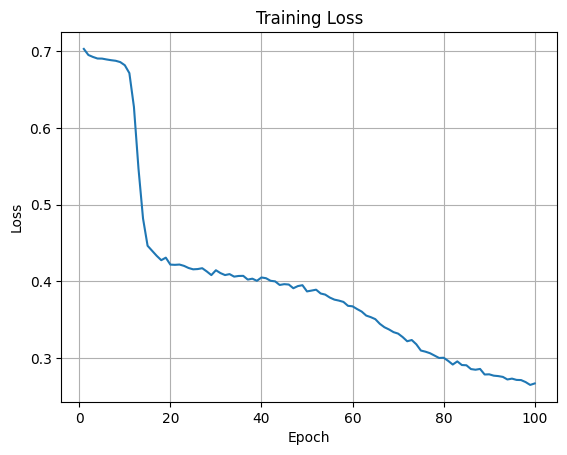

In [218]:
plt.plot(range(1, NUM_EPOCHS + 1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Run validation prediction on all faces

In [219]:
preds = []

with torch.no_grad():
    model.eval()

    for file_path in all_faces:
        transfom = transforms.ToTensor()

        img = Image.open(file_path)
        img = transfom(img).unsqueeze(0).to(DEVICE)

        y_pred = model(img).item()
        preds.append(y_pred)

preds = np.array(preds)

Display 200 predictions that are not not previously labeled.

We'll only consider predictions greater than or equal to 0.7 to be valid.

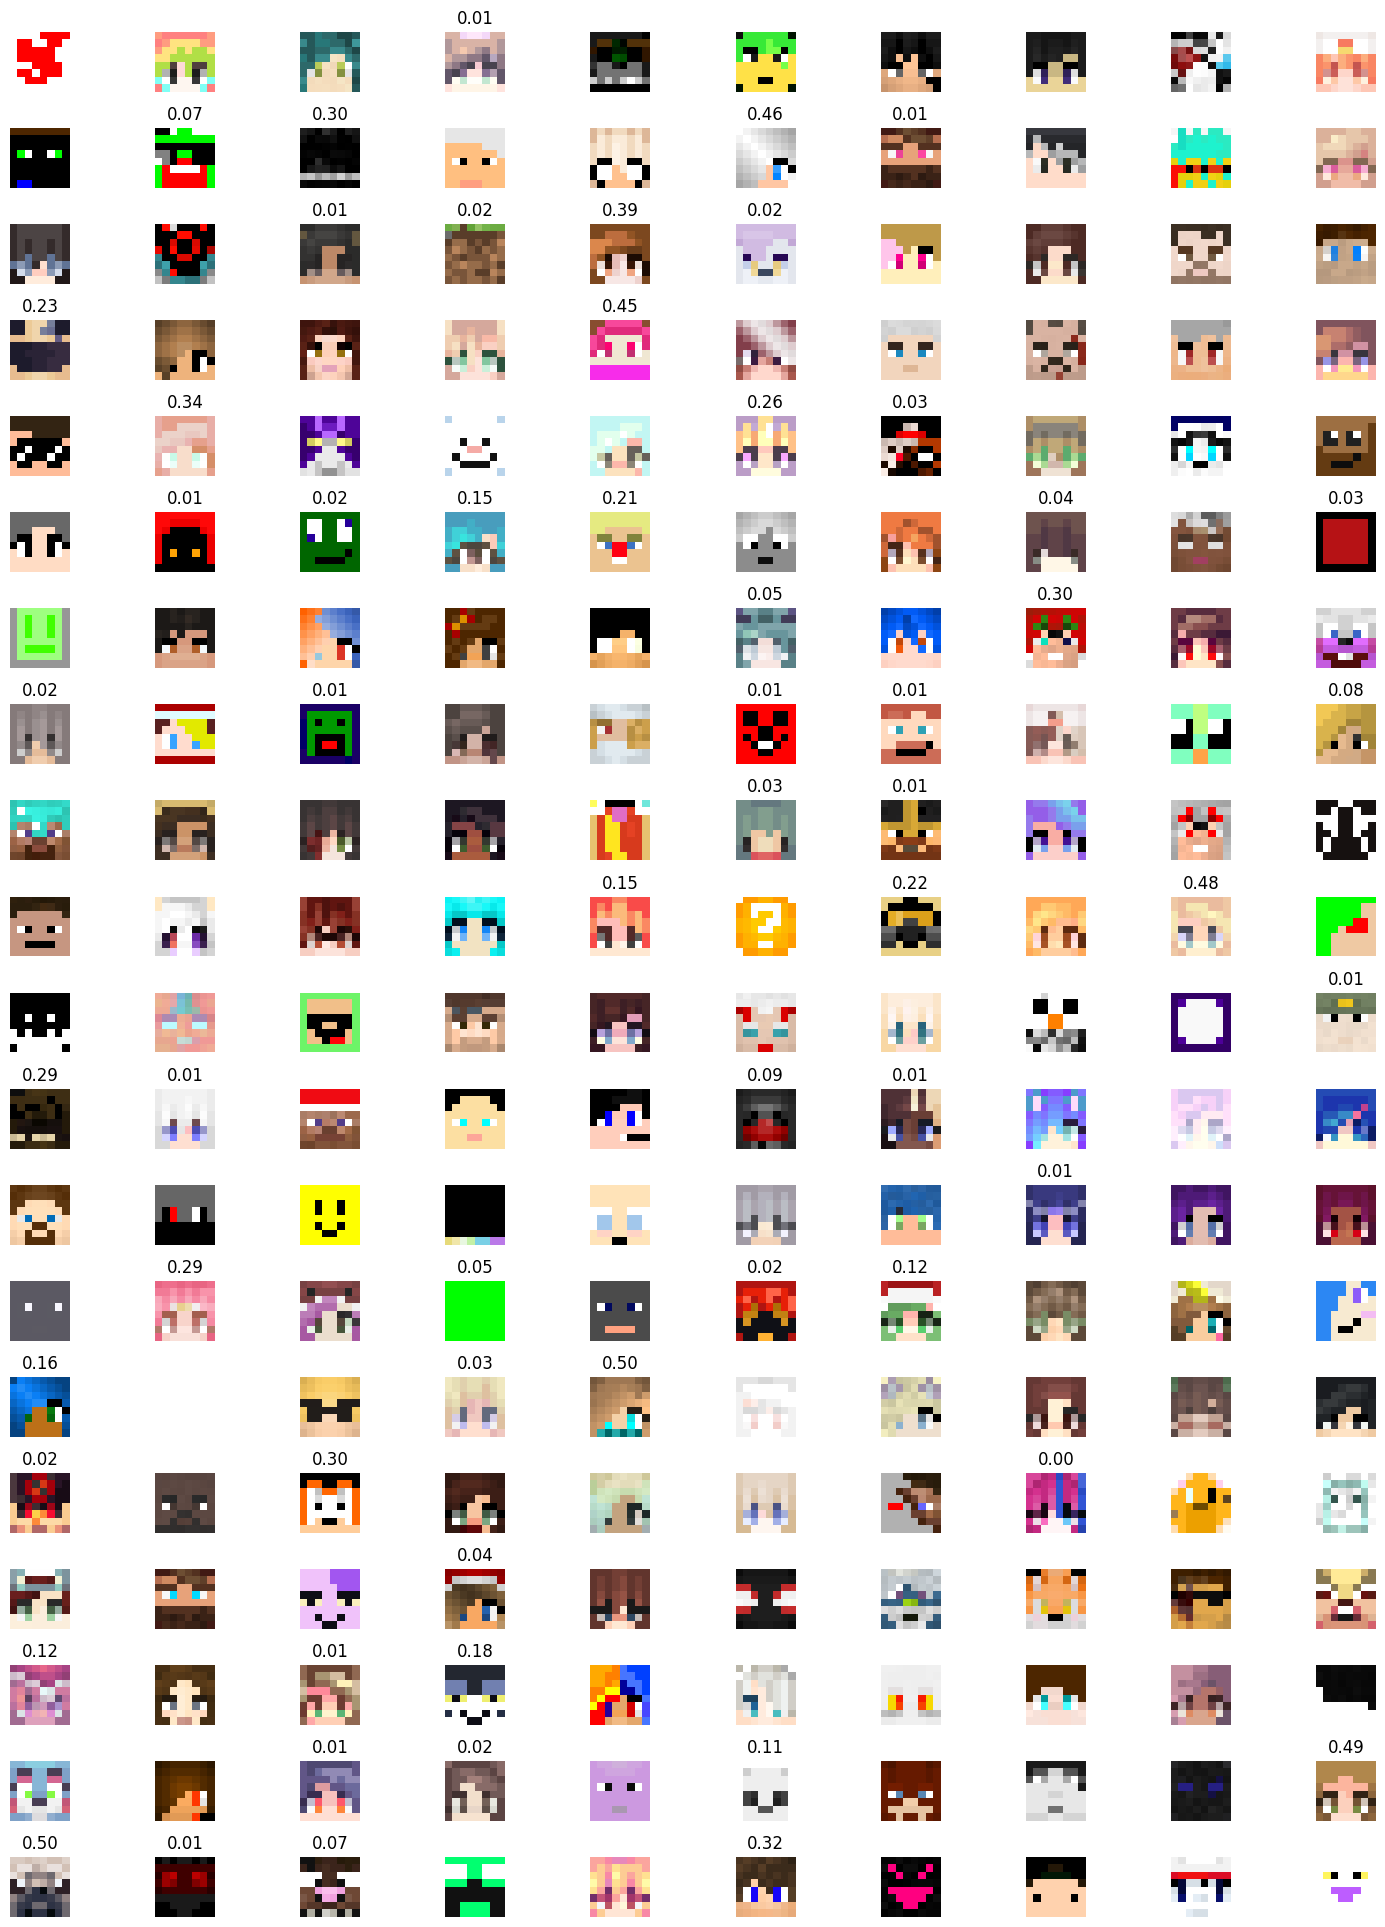

In [222]:
fig, axs = plt.subplots(20, 10, figsize=(15, 20))

labeled_faces = zip(all_faces[700:900], preds[1000:1200])

for i, (face_file, pred_val) in enumerate(labeled_faces):
    img = mpimg.imread(face_file)

    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')

    title = f'{pred_val:.02f}' if pred_val < 0.5 else ''

    axs[i // 10, i % 10].set_title(title)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

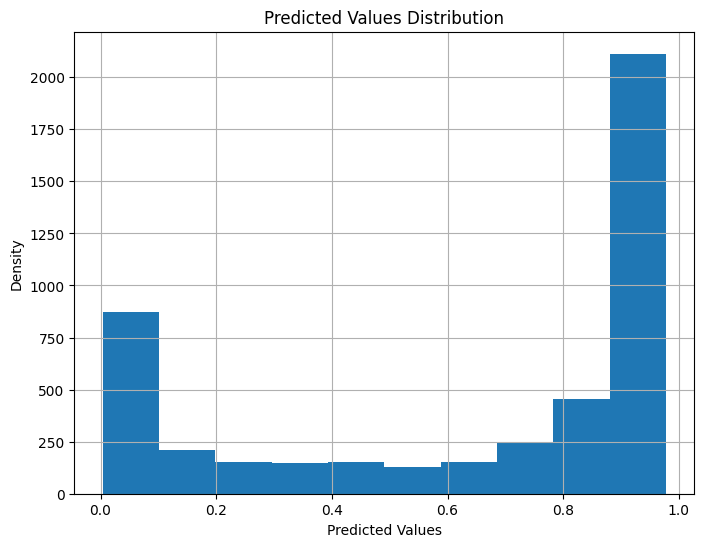

In [221]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normal_distribution(preds):
    plt.figure(figsize=(8, 6))
    plt.hist(preds, bins=10)
    plt.title('Predicted Values Distribution')
    plt.xlabel('Predicted Values')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# Example usage
plot_normal_distribution(preds)


In [240]:
count = 0
for _ in range(1000):
    if model(torch.tensor(np.random.randint(0, 256, (3, 8, 8)) / 255, device=DEVICE, dtype=torch.float).unsqueeze(0)) > 0.5:
        count+=1
print(count)

3


## Saving

Save model parameters

In [226]:
torch.save(model.state_dict(), VALIDATION_MODEL_PATH)

Save valid files

In [182]:
valid_face_indexes = np.array(
    np.where(preds >= 0.7)).squeeze()

In [188]:
if not os.path.isdir(VALID_FACE_DIR):
    os.mkdir(VALID_FACE_DIR)

for valid_index in valid_face_indexes:
    file_name = all_faces[valid_index].split('/')[-1]
    new_path = join(VALID_FACE_DIR, file_name)
    shutil.copy(
        all_faces[valid_index],
        new_path
    )